First Order Experiments with Hamiltonian $H = v^2/2 + x^2/2$. We record the error and compute time of each experiment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 8,8
import time


#exact solution at time $t$
################################
def get_F(Nx,Nv,t=0):
    """
    initial conditions for f
    X,V are assumed to be meshed numpy arrays
    """
    X = np.linspace(-1,1, Nx+1) + 1/Nx # the points x_{i}, X[0], X[-1] define the same point
    V = np.linspace(-1,1,Nv+1) + 1/Nv
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Xp = X*np.cos(t) - V*np.sin(t)
    Vp = V*np.cos(t) + X*np.sin(t)
    fo = np.exp(-20*(Vp-.3)**2 - 20*(Xp)**2)
    
    # inposes periodicity
    fo[-1,:] = fo[0,:]
    fo[:,-1] = fo[:,0]
    return fo
################################

def get_H_ders(F):
    U = np.zeros_like(F)
    K = np.zeros_like(F)
    
    V = np.linspace(-1,1,Nv+1)
    X = np.linspace(-1,1, Nv+1)
    
    K, U = np.meshgrid(V,X)
    K = K
    U = -U
    
    return K,U

In [2]:
def get_fluxes(F, K, U):
    """
    Gives the upwinded fluxes at each timestep
    
    inputs F,K, U 
    returns fluxes Fx, Fv as numpy arrays
    """
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    
    Fx[1:, :] = K[1:,:]*(F[1:,:] + F[0:-1,:])/2 - abs(K[1:,:])*(F[1:,:] -  F[0:-1,:])/2
    Fv[:, 1:] = U[:,1:]*(F[:,1:]+ F[:,0:-1])/2 - abs(U[:,1:])*(F[:,1:]- F[:,0:-1])/2
    Fx[0,:] = Fx[-1,:]
    Fv[:,0] = Fv[:,-1]
    return Fx, Fv

def frd_euler_step(F, Fx, Fv, dt, dx, dv):
    """
    outputs a forward euler step using first order upwinding
    """
    F[0:-1,0:-1] = F[0:-1,0:-1] - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    F[-1,0:-1] = F[0,0:-1]
    F[0:-1,-1] = F[0:-1,0]
    F[-1,-1] = F[0,0]
    return F

def first_order_integrate(F,K,U, dt, Nx, Nv, tfin):
    """
    integrates the vlasov equation with a fixed hamiltonian using 1st order upwinding
    returns a numpy array of $t_{n}$, $L^1(t)$, $L^2(t)$, $f(t_{f})$
    """
    dx = 2/Nx
    dv = 2/Nv
    num_time_steps = math.ceil(tfin/dt)
    times = np.arange(num_time_steps)*dt
    errors = [0]
    for t in times[1:]:
        Fx, Fv = get_fluxes(F,K,U)
        F = frd_euler_step(F, Fx, Fv, dt, dx, dv)
        Ftrue = get_F(Nx,Nv,t)
        errors.append(np.sum(abs(F[0:-1,0:-1]-Ftrue[0:-1,0:-1]))*dx*dv)

    return times, errors, F

def first_order_integrate_fast(F,K,U, dt, Nx, Nv, tfin):
    """
    first order integrate without the bloat functionality
    """
    dx = 2/Nx
    dv = 2/Nv
    num_time_steps = math.ceil(tfin/dt)
    for _ in range(num_time_steps-1):
        Fx, Fv = get_fluxes(F,K,U)
        F = frd_euler_step(F, Fx, Fv, dt, dx, dv)
    return F

In [3]:
Nx = 128
Nv = 128
dx = 2/Nx


F = get_F(Nx,Nv)
K, U = get_H_ders(F)

times_firstorder_128, errors_firstorder_128, F = first_order_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F(Nx,Nv)

time128_start = time.perf_counter()
F = first_order_integrate_fast(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
time128 =  time.perf_counter() - time128_start

Nx = 64
Nv = 64
dx = 2/Nx

F = get_F(Nx,Nv)
K, U = get_H_ders(F)
times_firstorder_64, errors_firstorder_64, F = first_order_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F(Nx,Nv)
time64_start = time.perf_counter()
F=first_order_integrate_fast(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
time64 =  time.perf_counter() - time64_start

Nx = 256
Nv = 256
dx = 2/Nx

F = get_F(Nx,Nv)
K, U = get_H_ders(F)
times_firstorder_256, errors_firstorder_256, F = first_order_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F(Nx,Nv)
time256_start =  time.perf_counter()
F = first_order_integrate_fast(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
time256 =  time.perf_counter() - time256_start

Nx = 32
Nv = 32
dx = 2/Nx

F = get_F(Nx,Nv)
K, U = get_H_ders(F)
times_firstorder_32, errors_firstorder_32, F = first_order_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F(Nx,Nv)
time32_start =  time.perf_counter()
F = first_order_integrate_fast(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
time32 =  time.perf_counter() - time32_start

Nx = 512
Nv = 512
dx = 2/Nx

F = get_F(Nx,Nv)
K, U = get_H_ders(F)
times_firstorder_512, errors_firstorder_512, F = first_order_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F(Nx,Nv)
time512_start =  time.perf_counter()
F = first_order_integrate_fast(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
time512 =  time.perf_counter() - time512_start

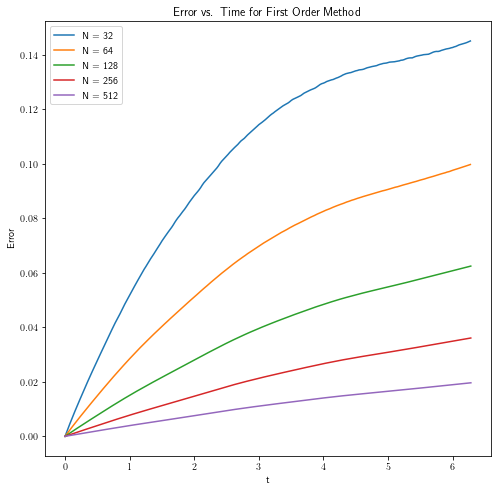

Total Compute Time for N = 32: 0.025s, Final Error: 0.14508
Total Compute Time for N = 64: 0.081s, Final Error: 0.09975
Total Compute Time for N = 128: 0.475s, Final Error: 0.06247
Total Compute Time for N = 256: 9.171s, Final Error: 0.03608
Total Compute Time for N = 512: 108.992s, Final Error: 0.01964


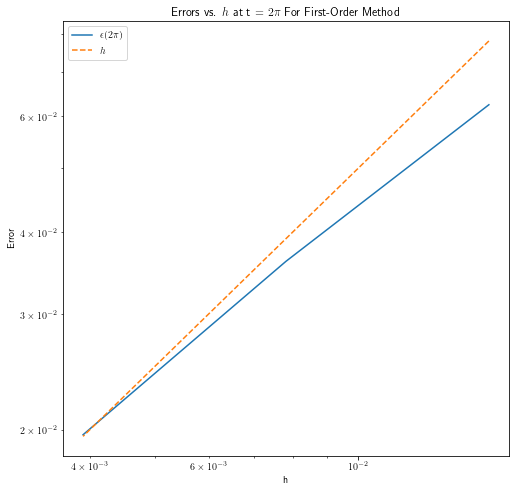

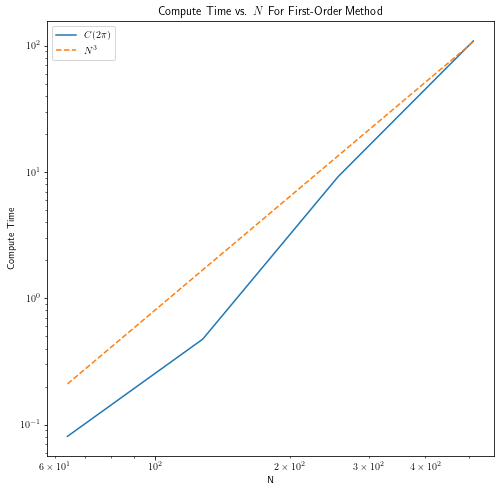

In [13]:
plt.plot(times_firstorder_32, errors_firstorder_32, label = "N = 32")
plt.plot(times_firstorder_64, errors_firstorder_64, label = "N = 64")
plt.plot(times_firstorder_128, errors_firstorder_128, label = "N = 128")
plt.plot(times_firstorder_256, errors_firstorder_256, label = "N = 256")
plt.plot(times_firstorder_512, errors_firstorder_512, label = "N = 512")
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Error vs. Time for First Order Method")
plt.legend()
plt.show()

print(f"Total Compute Time for N = 32: {time32:.3f}s, Final Error: {errors_firstorder_32[-1]:.5f}")
print(f"Total Compute Time for N = 64: {time64:.3f}s, Final Error: {errors_firstorder_64[-1]:.5f}")
print(f"Total Compute Time for N = 128: {time128:.3f}s, Final Error: {errors_firstorder_128[-1]:.5f}")
print(f"Total Compute Time for N = 256: {time256:.3f}s, Final Error: {errors_firstorder_256[-1]:.5f}")
print(f"Total Compute Time for N = 512: {time512:.3f}s, Final Error: {errors_firstorder_512[-1]:.5f}")

hs = [2/32, 2/64, 2/128, 2/256, 2/512]
errors = [errors_firstorder_32[-1], errors_firstorder_64[-1], errors_firstorder_128[-1],\
          errors_firstorder_256[-1], errors_firstorder_512[-1]]
compute_times = [time32, time64, time128, time256, time512]
N = [32, 64, 128, 256, 512]
plt.loglog(hs[2:], errors[2:],  label = "$\epsilon(2\pi)$")
plt.title("Errors vs. $h$ at t = $2\pi$ For First-Order Method")
plt.loglog(hs[2:], 5*np.array(hs[2:]), linestyle = "dashed", label = "$h$")
plt.legend()
plt.xlabel("h")
plt.ylabel("Error")
plt.show()

plt.loglog(N[1:], compute_times[1:],  label = "$C(2\pi)$")
plt.title("Compute Time vs. $N$ For First-Order Method")
plt.loglog(N[1:], .0000008* np.array(N[1:])**3, linestyle = "dashed", label = "$N^3$")
plt.legend()
plt.xlabel("N")
plt.ylabel("Compute Time")
plt.show()


We now turn to the second order method.

In [20]:
import numpy as np
# F, K, U assumed to be $Nx+3 x Nv + 3$ arrays
# the periodicity condition is v[0] = v[-3], v[1] = v[-2], v[2] = v[-1]
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 8,8
import time


#exact solution at time $t$
################################
def get_F_2(Nx,Nv,t=0):
    """
    initial conditions for f
    X,V are assumed to be meshed numpy arrays
    """
    X = np.linspace(-1,1 + 4/Nx, Nx+3) + 1/Nx # the points x_{i}, X[0], X[-1] define the same point
    V = np.linspace(-1,1 + 4/Nx,Nv+3) + 1/Nv
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Xp = X*np.cos(t) - V*np.sin(t)
    Vp = V*np.cos(t) + X*np.sin(t)
    fo = np.exp(-20*(Vp-.3)**2 - 20*(Xp)**2)
    
    # inposes periodicity
    fo[-1,:] = fo[2,:]
    fo[:,-1] = fo[:,2]
    fo[-2, :] = fo[1,:]
    fo[:,-1] = fo[:,1]
    fo[-3,:] = fo[0,:]
    fo[:,-3] = fo[:,0]
    return fo
################################

def get_H_ders_2(F):
    U = np.zeros_like(F)
    K = np.zeros_like(F)
    
    V = np.linspace(-1,1 + 4/Nv, Nv+3)
    X = np.linspace(-1,1 + 4/Nx, Nv+3)
    
    K, U = np.meshgrid(V,X)
    K = K
    U = -U
    
    return K,U


def get_second_order_fluxes(F, K, U):
    """
    inputs F,K, U 
    returns fluxes Fx, Fv are numpy arrays of size Nx+, Nv+3
    """

    KF = np.zeros_like(F) # Gives $FK(x_{i},v_{j+1/2})$
    UF = np.zeros_like(F) # Gives $UK(x_{i},v_{j+1/2})$
    
    KF[2:-1,:] = K[2:-1,:]*(5*F[1:-2,:] + 5*F[2:-1,:] - F[0:-3,:] - F[3:,:])/8 \
    + abs(K[2:-1,:])*(3*F[1:-2,:] - 3*F[2:-1,:] - F[0:-3,:] + F[3:,:])/8
    
    #periodicity 
    KF[0,:] = KF[-3,:]
    KF[1,:] = KF[-2,:]
    KF[-1,:] = KF[2,:]
    
    UF[:, 2:-1] = U[:, 2:-1]*(5*F[:,1:-2] + 5*F[:, 2:-1] - F[:, 0:-3] - F[:, 3:])/8 \
    + abs(U[:, 2:-1])*(3*F[:, 1:-2] - 3*F[:, 2:-1] - F[:, 0:-3] + F[:, 3:])/8
    
    #periodicity 
    UF[:,0] = UF[:,-3]
    UF[:, 1] = UF[:,-2]
    UF[:, -1] = UF[:, 2]

    return KF, UF


def get_k(F, K, U, dx, dv, dt):
    """
    gives k*dt
    """
    Fx, Fv = get_second_order_fluxes(F,K,U)
    k = np.zeros_like(F)
    k[0:-1,0:-1] =  - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def RK2_integrate(F,K,U,dt,Nx,Nv,tfin):
    """
    integrates the vlasov equation with a fixed hamiltonian using RK(2) and a Fromm-like scheme
    returns a numpy array of $f(t_{n})$
    """
    dx = 2/Nx
    dv = 2/Nv
    num_time_steps = math.ceil(tfin/dt)
    times = np.arange(num_time_steps)*dt
    errors = [0]
    for t in times[1:]:
        k2 = get_k(F,K,U, dx, dv, dt/2)
        F = F + get_k(F+k2, K,U, dx, dv, dt)
        Ftrue = get_F_2(Nx, Nv, t)
        errors.append(np.sum(abs(F[0:-3,0:-3]- Ftrue[0:-3,0:-3]))*dv*dx)
    return times, errors, F

def RK2_integrate_fast(F,K,U,dt,Nx,Nv,tfin):
    """
    RK2 integrate without the extra functionality
    """
    dx = 2/Nx
    dv = 2/Nv
    num_time_steps = math.ceil(tfin/dt)
    for t in range(num_time_steps-1):
        k2 = get_k(F,K,U, dx, dv, dt/2)
        F = F + get_k(F+k2, K,U, dx, dv, dt)
    return F

In [21]:
Nx = 128
Nv = 128
dx = 2/Nx


F = get_F_2(Nx,Nv)
K, U = get_H_ders_2(F)

times_firstorder_128, errors_firstorder_128, F = RK2_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F_2(Nx,Nv)

time128_start = time.perf_counter()
F = RK2_integrate_fast(F, K,U, .4*dx, Nx, Nv, np.pi*2)
time128 =  time.perf_counter() - time128_start

Nx = 64
Nv = 64
dx = 2/Nx

F = get_F_2(Nx,Nv)
K, U = get_H_ders_2(F)
times_firstorder_64, errors_firstorder_64, F = RK2_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F_2(Nx,Nv)
time64_start = time.perf_counter()
F= RK2_integrate_fast(F, K,U, .4*dx, Nx, Nv, np.pi*2)
time64 =  time.perf_counter() - time64_start

Nx = 256
Nv = 256
dx = 2/Nx

F = get_F_2(Nx,Nv)
K, U = get_H_ders_2(F)
times_firstorder_256, errors_firstorder_256, F = RK2_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F_2(Nx,Nv)
time256_start =  time.perf_counter()
F = RK2_integrate_fast(F, K,U, .4*dx, Nx, Nv, np.pi*2)
time256 =  time.perf_counter() - time256_start

Nx = 32
Nv = 32
dx = 2/Nx

F = get_F_2(Nx,Nv)
K, U = get_H_ders_2(F)
times_firstorder_32, errors_firstorder_32, F = RK2_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F_2(Nx,Nv)
time32_start =  time.perf_counter()
F = RK2_integrate_fast(F, K,U, .4*dx, Nx, Nv, np.pi*2)
time32 =  time.perf_counter() - time32_start

Nx = 512
Nv = 512
dx = 2/Nx

F = get_F_2(Nx,Nv)
K, U = get_H_ders_2(F)
times_firstorder_512, errors_firstorder_512, F = RK2_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F_2(Nx,Nv)
time512_start =  time.perf_counter()
F = RK2_integrate_fast(F, K,U, .4*dx, Nx, Nv, np.pi*2)
time512 =  time.perf_counter() - time512_start

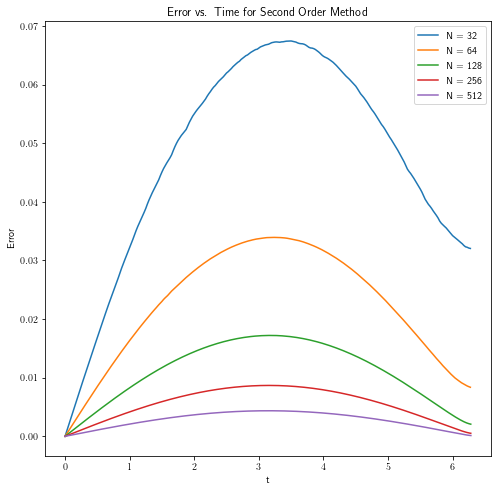

Total Compute Time for N = 256: 0.07s, Final Error: 0.03205
Total Compute Time for N = 64: 0.26s, Final Error: 0.00837
Total Compute Time for N = 128: 1.35s, Final Error: 0.00207
Total Compute Time for N = 256: 23.76s, Final Error: 0.00052
Total Compute Time for N = 512: 298.30s, Final Error: 0.00013


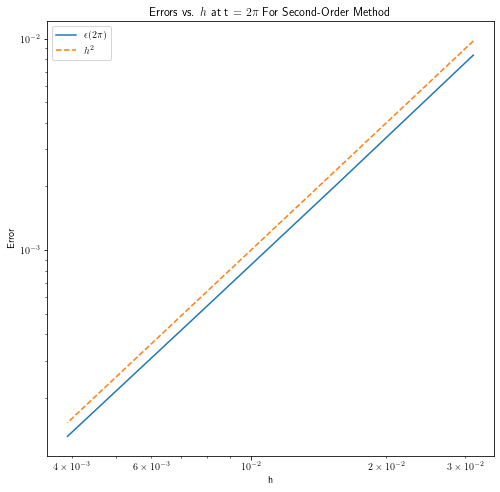

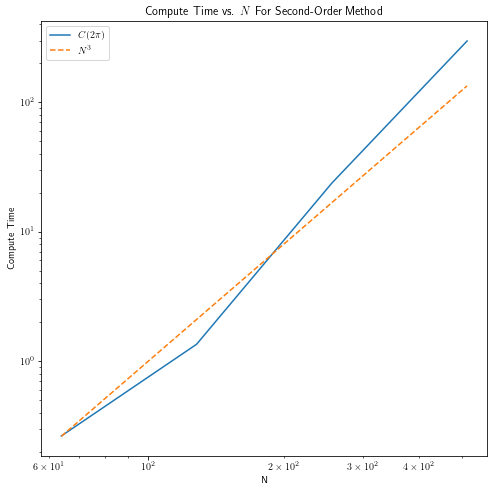

In [22]:
plt.plot(times_firstorder_32, errors_firstorder_32, label = "N = 32")
plt.plot(times_firstorder_64, errors_firstorder_64, label = "N = 64")
plt.plot(times_firstorder_128, errors_firstorder_128, label = "N = 128")
plt.plot(times_firstorder_256, errors_firstorder_256, label = "N = 256")
plt.plot(times_firstorder_512, errors_firstorder_512, label = "N = 512")
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Error vs. Time for Second Order Method")
plt.legend()
plt.show()

print(f"Total Compute Time for N = 256: {time32:.2f}s, Final Error: {errors_firstorder_32[-1]:.5f}")
print(f"Total Compute Time for N = 64: {time64:.2f}s, Final Error: {errors_firstorder_64[-1]:.5f}")
print(f"Total Compute Time for N = 128: {time128:.2f}s, Final Error: {errors_firstorder_128[-1]:.5f}")
print(f"Total Compute Time for N = 256: {time256:.2f}s, Final Error: {errors_firstorder_256[-1]:.5f}")
print(f"Total Compute Time for N = 512: {time512:.2f}s, Final Error: {errors_firstorder_512[-1]:.5f}")

hs = [2/32, 2/64, 2/128, 2/256, 2/512]
errors = [errors_firstorder_32[-1], errors_firstorder_64[-1], errors_firstorder_128[-1],\
          errors_firstorder_256[-1], errors_firstorder_512[-1]]
compute_times = [time32, time64, time128, time256, time512]
N = [32, 64, 128, 256, 512]
plt.loglog(hs[1:], errors[1:],  label = "$\epsilon(2\pi)$")
plt.title("Errors vs. $h$ at t = $2\pi$ For Second-Order Method")
plt.loglog(hs[1:], 10*np.array(hs[1:])**2, linestyle = "dashed", label = "$h^2$")
plt.legend()
plt.xlabel("h")
plt.ylabel("Error")
plt.show()

plt.loglog(N[1:], compute_times[1:],  label = "$C(2\pi)$")
plt.title("Compute Time vs. $N$ For Second-Order Method")
plt.loglog(N[1:], .000001* np.array(N[1:])**3, linestyle = "dashed", label = "$N^3$")
plt.legend()
plt.xlabel("N")
plt.ylabel("Compute Time")
plt.show()


We now do the moncen limiting

In [23]:
def get_moncen_slopes(F):
    """
    computes moncen limited slopes times dx or dv
    returns delta_{ij}^{x}, delta_{ij}^{v} as numpy arrays 
    """
    urx = np.zeros_like(F) # = \Delta u_{ij,r}^{x} * dx
    ulx = np.zeros_like(F) # = \Delta_{ij,l}^{x} * dx
    urv = np.zeros_like(F) # = \Delta_{ij,r}^{v} * dv
    ulv = np.zeros_like(F) # = \Delta_{ij,l}^{v} * dv
    
    urx[0:-1,:] = (F[1:,:] - F[0:-1,:])
    urx[-1,:] = urx[2,:] 
    ulx[1:,:] = (F[1:,:] - F[0:-1,:])
    ulx[0,:] = ulx[-3,:]
    urv[:, 0:-1] = (F[:,1:]-F[:,0:-1])
    urv[:,-1] = urv[:,2]
    ulv[:, 1:] = (F[:,1:] - F[:,0:-1])
    ulv[:,0] = ulv[:,-3]
    
    ucx = (urx+ulx)/2 # average slops
    ucv = (urv + ulv)/2 
    
    # gives sign of slope
    # gives zero if u_{l} and u_{r} have different signs 
    
    signsx = np.heaviside(urx*ulx,0) * np.sign(urx)
    signsv = np.heaviside(urv*ulv,0) * np.sign(urv)
    
    # gives minmod limited slopes 
    
    ux = signsx * np.minimum(np.minimum(2*abs(urx), 2*abs(ulx)), abs(ucx))
    uv = signsv * np.minimum(np.minimum(2*abs(urv),2*abs(ulv)), abs(ucv))
    
    return ux, uv


    
def get_moncen_limited_fluxes(F, K, U):
    """
    returns upwinded, moncen limited fluxes
    inputs F, K, U 
    returns upwinded fluxes Fx, Fv are numpy arrays of size Nx+, Nv+3
    """
    ux, uv = get_moncen_slopes(F)
    
    Kp = np.maximum(0,K)
    Km = np.minimum(0,K)
    Up = np.maximum(0,U)
    Um = np.minimum(0,U)
    
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    
    Fx[1:,:] = Kp[1:,:]*(F[0:-1,:] + .5*ux[0:-1,:]) + Km[1:,:]*(F[1:,:] - .5*ux[1:,:])
    Fx[0,:] = Fx[-3,:]
    
    Fv[:, 1:] = Up[:,1:] *(F[:,0:-1] + .5*uv[:,0:-1]) + Um[:,1:]*(F[:,1:] - .5*uv[:,1:])
    Fv[:,0] = Fv[:,-3]

    return Fx, Fv


def moncen_get_k(F, K, U, dx, dv, dt):
    """
    gives k*dt for runge kutta predictor step
    """
    Fx, Fv = get_moncen_limited_fluxes(F,K,U)
    
    k = np.zeros_like(F)
    k[0:-1,0:-1] =  -dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def moncen_RK2_step(F, K, U, dx, dv, dt):
    """
    corrector step for RK2 
    edge values are limited here too
    """
    
    Fx, Fv = get_moncen_limited_fluxes(F,K,U)
    k = np.zeros_like(F)
    k[0:-1,0:-1] = - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def moncen_RK2_integrate(F,K,U,dt, Nx, Nv, tfin):
    """
    integrates the vlasov equation with a fixed hamiltonian using RK(2) and a moncen limiting
    returns a numpy array of $f(t_{n})$
    """
    dx = 2/Nx
    dv = 2/Nv
    
    num_time_steps = math.ceil(tfin/dt)
    times = dt*np.arange(num_time_steps)
    errors = [0]
    
    for t in times[1:]:
        k2 = moncen_get_k(F,K,U, dx, dv, dt/2)
        F = F + moncen_RK2_step(F+k2, K,U, dx, dv, dt)
        Ftrue = get_F_2(Nx, Nv, t)
        errors.append(np.sum(abs(Ftrue[0:-3,0:-3]-F[0:-3,0:-3]))*dx*dv)
        
    return times, errors, F

def moncen_RK2_integrate_fast(F,K,U,dt, Nx, Nv, tfin):
    """
    integrates the vlasov equation with a fixed hamiltonian using RK(2) and a moncen limiting
    returns a numpy array of $f(t_{n})$
    """
    dx = 2/Nx
    dv = 2/Nv
    
    num_time_steps = math.ceil(tfin/dt)
    
    for _ in range(num_time_steps-1):
        k2 = moncen_get_k(F,K,U, dx, dv, dt/2)
        F = F + moncen_RK2_step(F+k2, K,U, dx, dv, dt)
        
    return F

In [24]:
Nx = 128
Nv = 128
dx = 2/Nx


F = get_F_2(Nx,Nv)
K, U = get_H_ders_2(F)

times_firstorder_128, errors_firstorder_128, F = moncen_RK2_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F_2(Nx,Nv)

time128_start = time.perf_counter()
F = moncen_RK2_integrate_fast(F, K,U, .4*dx, Nx, Nv, np.pi*2)
time128 =  time.perf_counter() - time128_start

Nx = 64
Nv = 64
dx = 2/Nx

F = get_F_2(Nx,Nv)
K, U = get_H_ders_2(F)
times_firstorder_64, errors_firstorder_64, F = moncen_RK2_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F_2(Nx,Nv)
time64_start = time.perf_counter()
F= moncen_RK2_integrate_fast(F, K,U, .4*dx, Nx, Nv, np.pi*2)
time64 =  time.perf_counter() - time64_start

Nx = 256
Nv = 256
dx = 2/Nx

F = get_F_2(Nx,Nv)
K, U = get_H_ders_2(F)
times_firstorder_256, errors_firstorder_256, F = moncen_RK2_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F_2(Nx,Nv)
time256_start =  time.perf_counter()
F = moncen_RK2_integrate_fast(F, K,U, .4*dx, Nx, Nv, np.pi*2)
time256 =  time.perf_counter() - time256_start

Nx = 32
Nv = 32
dx = 2/Nx

F = get_F_2(Nx,Nv)
K, U = get_H_ders_2(F)
times_firstorder_32, errors_firstorder_32, F = moncen_RK2_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F_2(Nx,Nv)
time32_start =  time.perf_counter()
F = moncen_RK2_integrate_fast(F, K,U, .4*dx, Nx, Nv, np.pi*2)
time32 =  time.perf_counter() - time32_start

Nx = 512
Nv = 512
dx = 2/Nx

F = get_F_2(Nx,Nv)
K, U = get_H_ders_2(F)
times_firstorder_512, errors_firstorder_512, F = moncen_RK2_integrate(F, K,U, .4*dx, Nx, Nv, 2*np.pi)
F = get_F_2(Nx,Nv)
time512_start =  time.perf_counter()
F = moncen_RK2_integrate_fast(F, K,U, .4*dx, Nx, Nv, np.pi*2)
time512 =  time.perf_counter() - time512_start


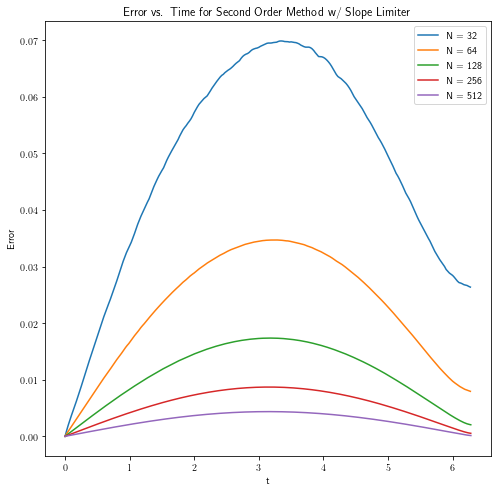

Total Compute Time for N = 256: 0.12s, Final Error: 0.02637
Total Compute Time for N = 64: 0.51s, Final Error: 0.00795
Total Compute Time for N = 128: 2.94s, Final Error: 0.00204
Total Compute Time for N = 256: 30.14s, Final Error: 0.00053
Total Compute Time for N = 512: 501.40s, Final Error: 0.00014


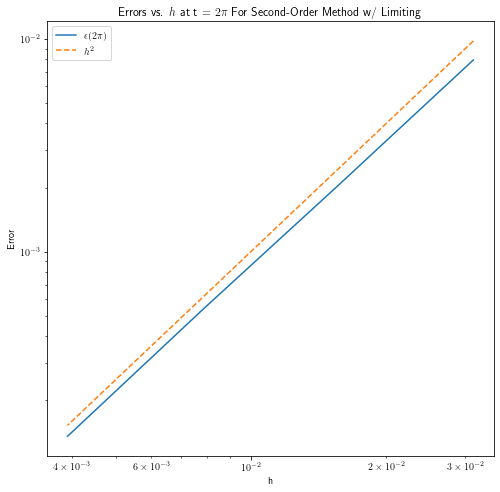

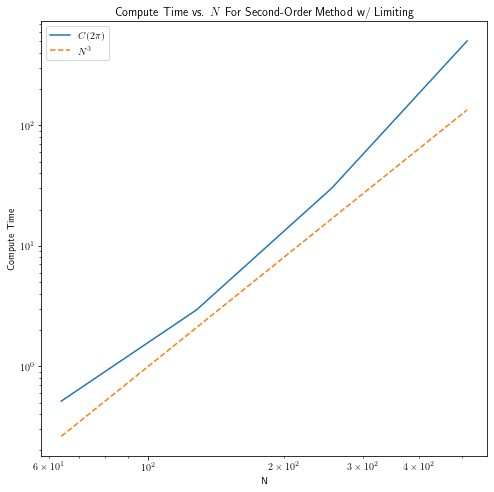

In [25]:
plt.plot(times_firstorder_32, errors_firstorder_32, label = "N = 32")
plt.plot(times_firstorder_64, errors_firstorder_64, label = "N = 64")
plt.plot(times_firstorder_128, errors_firstorder_128, label = "N = 128")
plt.plot(times_firstorder_256, errors_firstorder_256, label = "N = 256")
plt.plot(times_firstorder_512, errors_firstorder_512, label = "N = 512")
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Error vs. Time for Second Order Method w/ Slope Limiter")
plt.legend()
plt.show()

print(f"Total Compute Time for N = 256: {time32:.2f}s, Final Error: {errors_firstorder_32[-1]:.5f}")
print(f"Total Compute Time for N = 64: {time64:.2f}s, Final Error: {errors_firstorder_64[-1]:.5f}")
print(f"Total Compute Time for N = 128: {time128:.2f}s, Final Error: {errors_firstorder_128[-1]:.5f}")
print(f"Total Compute Time for N = 256: {time256:.2f}s, Final Error: {errors_firstorder_256[-1]:.5f}")
print(f"Total Compute Time for N = 512: {time512:.2f}s, Final Error: {errors_firstorder_512[-1]:.5f}")

hs = [2/32, 2/64, 2/128, 2/256, 2/512]
errors = [errors_firstorder_32[-1], errors_firstorder_64[-1], errors_firstorder_128[-1],\
          errors_firstorder_256[-1], errors_firstorder_512[-1]]
compute_times = [time32, time64, time128, time256, time512]
N = [32, 64, 128, 256, 512]
plt.loglog(hs[1:], errors[1:],  label = "$\epsilon(2\pi)$")
plt.title("Errors vs. $h$ at t = $2\pi$ For Second-Order Method w/ Limiting")
plt.loglog(hs[1:], 10*np.array(hs[1:])**2, linestyle = "dashed", label = "$h^2$")
plt.legend()
plt.xlabel("h")
plt.ylabel("Error")
plt.show()

plt.loglog(N[1:], compute_times[1:],  label = "$C(2\pi)$")
plt.title("Compute Time vs. $N$ For Second-Order Method w/ Limiting")
plt.loglog(N[1:], .000001* np.array(N[1:])**3, linestyle = "dashed", label = "$N^3$")
plt.legend()
plt.xlabel("N")
plt.ylabel("Compute Time")
plt.show()
